##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [5]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

/Users/watcharinsarachai/.keras/datasets/jena_climate_2009_2016_extracted
/Users/watcharinsarachai/.keras/datasets/jena_climate_2009_2016_extracted


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [6]:
df = pd.read_csv(csv_path+'/jena_climate_2009_2016.csv')
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

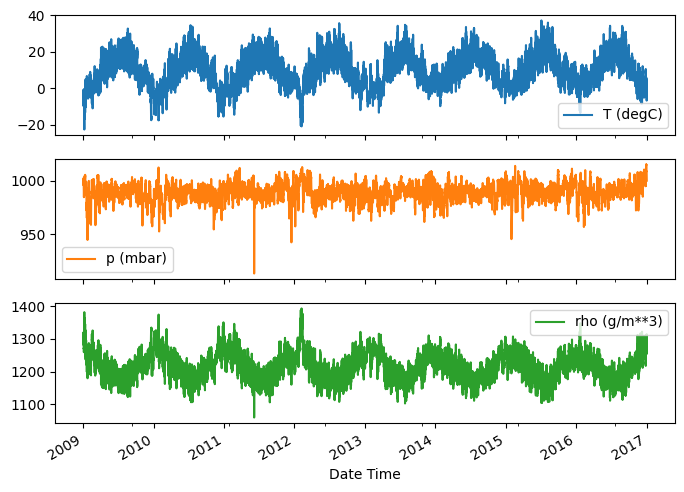

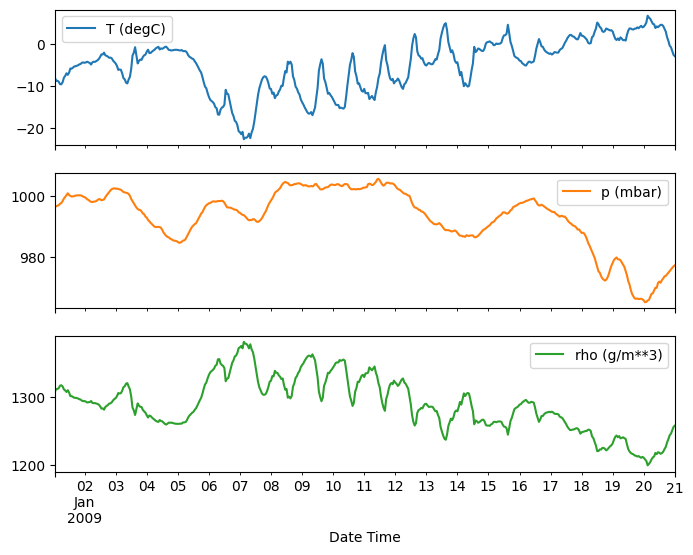

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

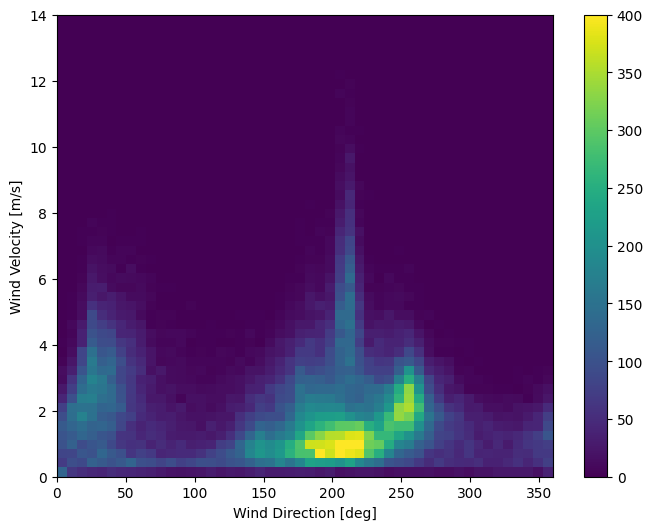

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

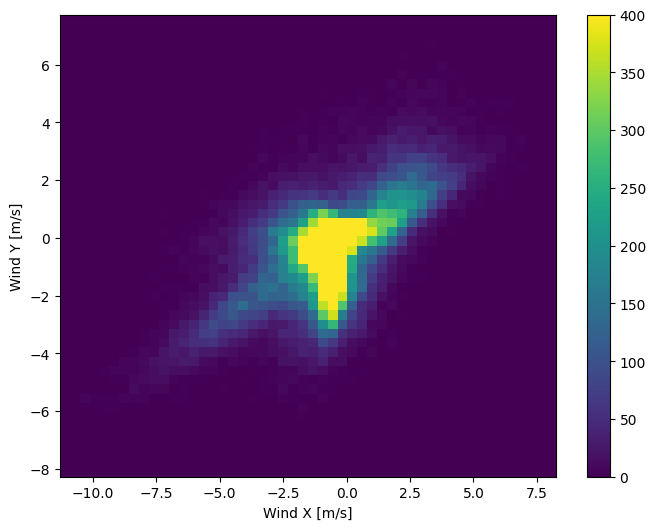

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

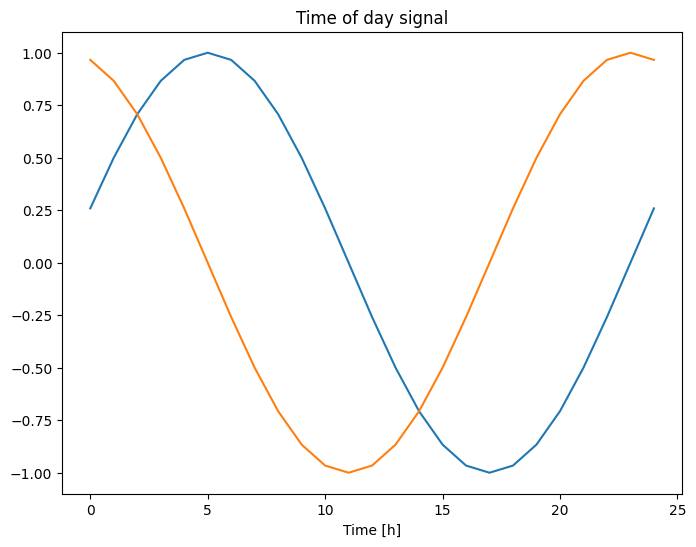

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


I0000 00:00:1723775833.614540   80658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775833.618414   80658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775833.622101   80658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775833.625816   80658 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

I0000 00:00:1723775833.663146   80658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775834.884491   80658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775834.886647   80658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723775834.888756   80658 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

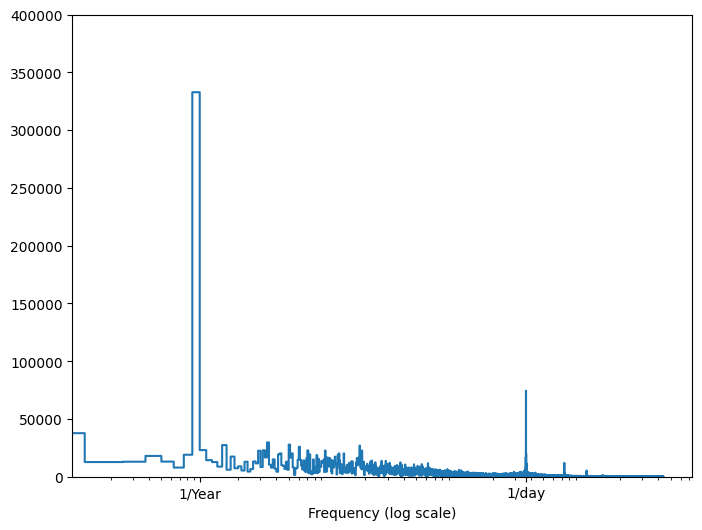

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

/tmpfs/tmp/ipykernel_80658/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


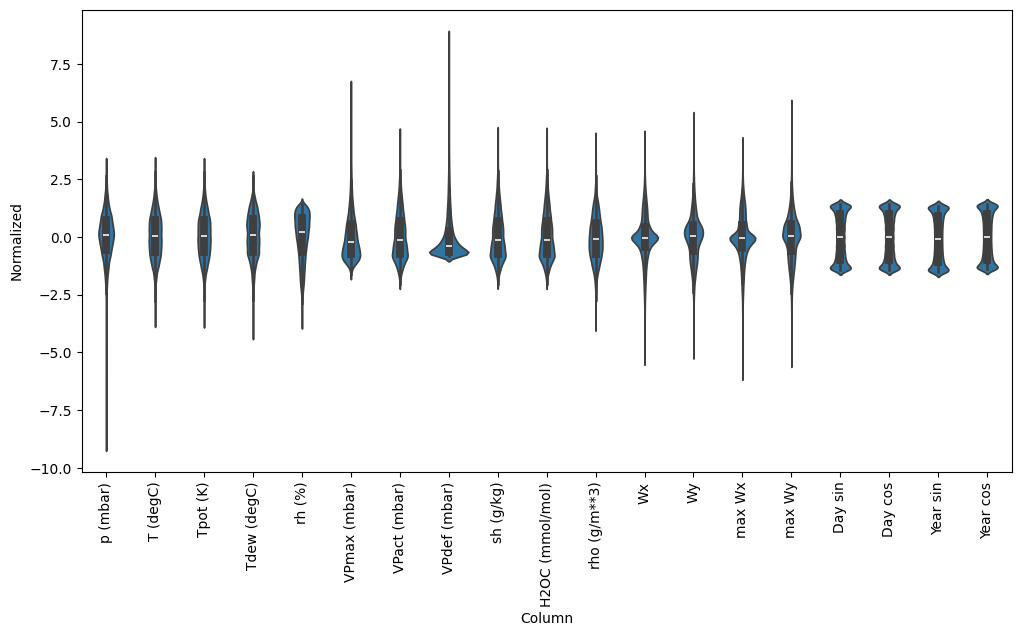

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

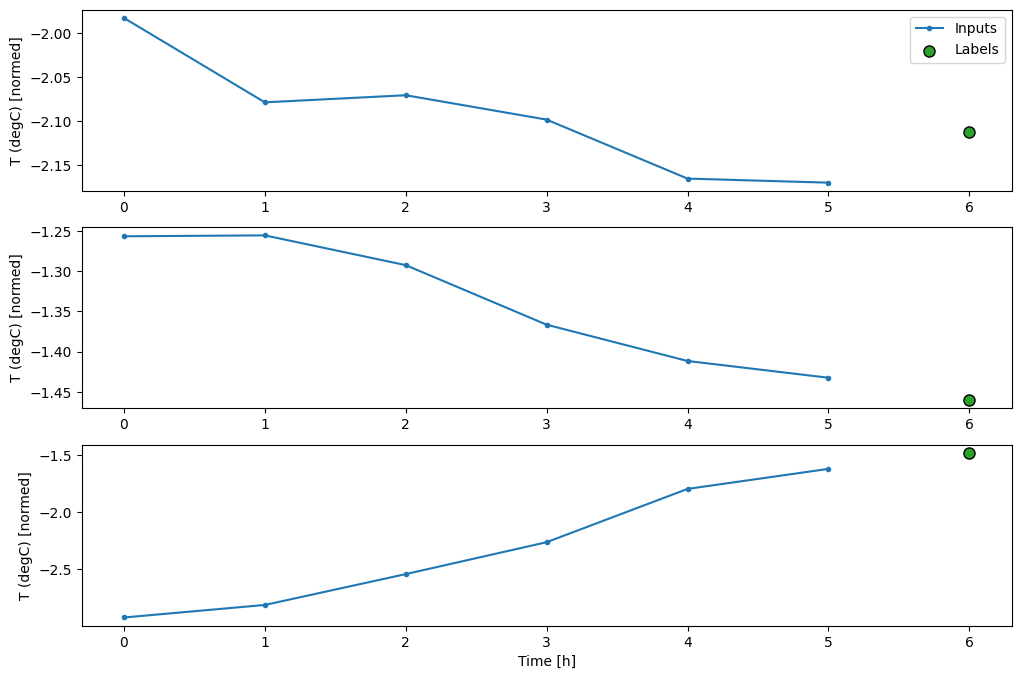

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

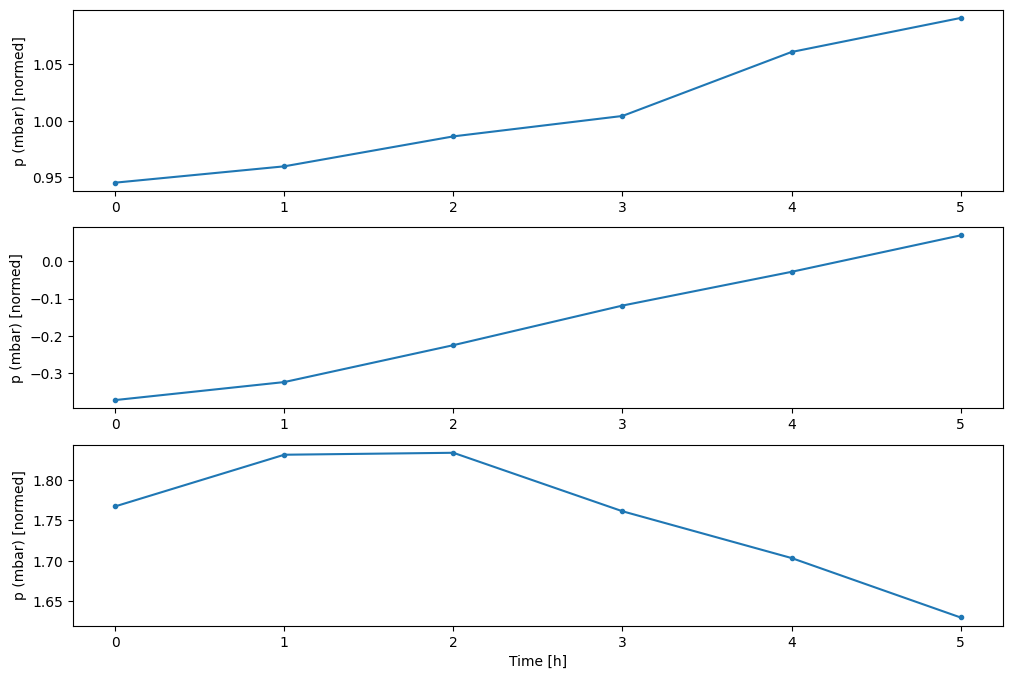

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

  1/439 ━━━━━━━━━━━━━━━━━━━━ 2:27 337ms/step - loss: 0.0075 - mean_absolute_error: 0.0657

I0000 00:00:1723775844.435380   80829 service.cc:146] XLA service 0x7eff1c004a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723775844.435411   80829 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1723775844.435416   80829 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1723775844.435419   80829 service.cc:154]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1723775844.435422   80829 service.cc:154]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5
I0000 00:00:1723775844.614710   80829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 38/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103 - mean_absolute_error: 0.0724    

 80/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110 - mean_absolute_error: 0.0746

122/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - mean_absolute_error: 0.0755

164/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - mean_absolute_error: 0.0760

207/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - mean_absolute_error: 0.0762

250/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - mean_absolute_error: 0.0763

291/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - mean_absolute_error: 0.0763

335/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - mean_absolute_error: 0.0765

382/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0120 - mean_absolute_error: 0.0767

428/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - mean_absolute_error: 0.0769

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - mean_absolute_error: 0.0769

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0121 - mean_absolute_error: 0.0769


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

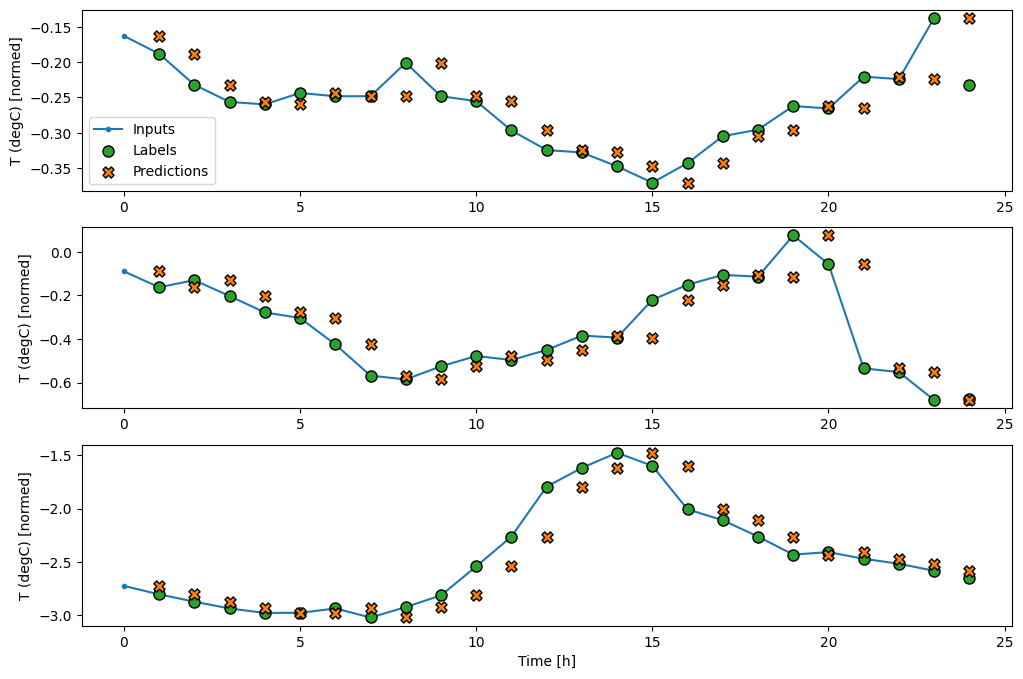

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 21:51 856ms/step - loss: 2.1417 - mean_absolute_error: 1.1814

  39/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5030 - mean_absolute_error: 1.2593     

  79/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2471 - mean_absolute_error: 1.1913

 123/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0225 - mean_absolute_error: 1.1219

 164/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8576 - mean_absolute_error: 1.0669

 207/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7156 - mean_absolute_error: 1.0171

 246/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6083 - mean_absolute_error: 0.9780

 285/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5164 - mean_absolute_error: 0.9435

 324/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4367 - mean_absolute_error: 0.9127

 364/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3650 - mean_absolute_error: 0.8842

 404/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3016 - mean_absolute_error: 0.8583

 445/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2435 - mean_absolute_error: 0.8341

 486/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1914 - mean_absolute_error: 0.8119

 527/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1442 - mean_absolute_error: 0.7913

 568/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1013 - mean_absolute_error: 0.7720

 609/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0619 - mean_absolute_error: 0.7540

 650/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0257 - mean_absolute_error: 0.7371

 691/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9923 - mean_absolute_error: 0.7211

 732/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9612 - mean_absolute_error: 0.7060

 773/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9324 - mean_absolute_error: 0.6916

 812/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9067 - mean_absolute_error: 0.6787

 851/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8826 - mean_absolute_error: 0.6663

 891/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8594 - mean_absolute_error: 0.6542

 933/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8365 - mean_absolute_error: 0.6421

 974/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8154 - mean_absolute_error: 0.6308

1017/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7946 - mean_absolute_error: 0.6195

1059/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7754 - mean_absolute_error: 0.6090

1099/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7581 - mean_absolute_error: 0.5993

1139/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7416 - mean_absolute_error: 0.5901

1179/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7260 - mean_absolute_error: 0.5812

1221/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7104 - mean_absolute_error: 0.5722

1261/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6962 - mean_absolute_error: 0.5640

1301/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6826 - mean_absolute_error: 0.5561

1341/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6696 - mean_absolute_error: 0.5484

1379/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6578 - mean_absolute_error: 0.5414

1422/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6450 - mean_absolute_error: 0.5337

1462/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6336 - mean_absolute_error: 0.5269

1502/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6227 - mean_absolute_error: 0.5202

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6143 - mean_absolute_error: 0.5151

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6140 - mean_absolute_error: 0.5149 - val_loss: 0.0133 - val_mean_absolute_error: 0.0868


Epoch 2/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:28 57ms/step - loss: 0.0389 - mean_absolute_error: 0.1103

  37/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0164 - mean_absolute_error: 0.0905   

  78/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0148 - mean_absolute_error: 0.0886

 117/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0142 - mean_absolute_error: 0.0878

 156/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0138 - mean_absolute_error: 0.0870

 195/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0135 - mean_absolute_error: 0.0863

 236/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0859

 276/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131 - mean_absolute_error: 0.0855

 316/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129 - mean_absolute_error: 0.0851

 357/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0847

 398/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127 - mean_absolute_error: 0.0844

 439/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0126 - mean_absolute_error: 0.0841

 481/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0125 - mean_absolute_error: 0.0838

 526/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0124 - mean_absolute_error: 0.0836

 568/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0123 - mean_absolute_error: 0.0833

 610/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0123 - mean_absolute_error: 0.0831

 650/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0122 - mean_absolute_error: 0.0829

 689/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0122 - mean_absolute_error: 0.0827

 727/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0121 - mean_absolute_error: 0.0826

 766/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - mean_absolute_error: 0.0824

 806/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0120 - mean_absolute_error: 0.0822

 846/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0120 - mean_absolute_error: 0.0820

 888/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - mean_absolute_error: 0.0819

 930/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - mean_absolute_error: 0.0817

 974/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - mean_absolute_error: 0.0815

1016/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - mean_absolute_error: 0.0814

1056/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - mean_absolute_error: 0.0812

1095/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - mean_absolute_error: 0.0811

1136/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - mean_absolute_error: 0.0810

1178/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - mean_absolute_error: 0.0808

1219/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - mean_absolute_error: 0.0807

1259/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - mean_absolute_error: 0.0806

1301/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - mean_absolute_error: 0.0805

1342/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - mean_absolute_error: 0.0803

1384/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - mean_absolute_error: 0.0802

1424/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - mean_absolute_error: 0.0801

1465/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - mean_absolute_error: 0.0800

1506/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - mean_absolute_error: 0.0799

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0114 - mean_absolute_error: 0.0798 - val_loss: 0.0090 - val_mean_absolute_error: 0.0699


Epoch 3/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:23 54ms/step - loss: 0.0079 - mean_absolute_error: 0.0584

  39/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0685   

  79/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0701

 121/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

 162/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0704

 203/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0704

 244/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0704

 285/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0704

 325/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 369/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 409/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0703

 448/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0703

 488/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0703

 533/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 574/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 615/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 656/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 698/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 739/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 779/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 819/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0704

 858/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

 896/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

 935/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

 974/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1012/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1053/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1093/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1132/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1170/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1209/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1248/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1288/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1330/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0705

1370/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0704

1411/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0704

1451/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0704

1492/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0704

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0704 - val_loss: 0.0087 - val_mean_absolute_error: 0.0684


Epoch 4/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:25 56ms/step - loss: 0.0128 - mean_absolute_error: 0.0845

  39/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0112 - mean_absolute_error: 0.0726   

  78/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104 - mean_absolute_error: 0.0718

 117/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0100 - mean_absolute_error: 0.0711

 156/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097 - mean_absolute_error: 0.0706

 195/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095 - mean_absolute_error: 0.0702

 236/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0701

 276/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0700

 316/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0699

 354/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0698

 392/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0698

 431/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

 469/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

 509/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 550/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 592/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 633/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

 674/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

 715/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 756/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 798/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 840/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 882/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 924/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

 965/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

1006/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

1047/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

1089/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

1131/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

1173/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

1214/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

1255/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0697

1294/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

1334/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0696

1373/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0696

1412/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0696

1452/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0696

1493/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0696

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0681


Epoch 5/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:22 54ms/step - loss: 0.0044 - mean_absolute_error: 0.0547

  38/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0102 - mean_absolute_error: 0.0700   

  78/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099 - mean_absolute_error: 0.0704

 118/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096 - mean_absolute_error: 0.0701

 158/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0699

 198/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0696

 238/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0696

 279/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0696

 321/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0695

 362/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0695

 402/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 441/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 481/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 524/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 564/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 605/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 645/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 687/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 725/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 763/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 802/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 843/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 884/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 924/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 964/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1005/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1046/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1086/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1127/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1167/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1208/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1250/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1290/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1330/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1369/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1411/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1452/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1492/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1533/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0695 - val_loss: 0.0086 - val_mean_absolute_error: 0.0684


Epoch 6/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:24 55ms/step - loss: 0.0195 - mean_absolute_error: 0.0948

  38/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0101 - mean_absolute_error: 0.0705   

  75/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098 - mean_absolute_error: 0.0705

 115/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096 - mean_absolute_error: 0.0702

 157/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0698

 199/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0696

 243/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0695

 281/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0695

 320/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0694

 359/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 399/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 438/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 479/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 520/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 561/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 601/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 645/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 687/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 726/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 766/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 805/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 843/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 882/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 921/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 960/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1001/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1041/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1080/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1122/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1165/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1208/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1250/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1291/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1331/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1372/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1414/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1455/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1497/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0695

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0695 - val_loss: 0.0086 - val_mean_absolute_error: 0.0683


Epoch 7/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:24 55ms/step - loss: 0.0121 - mean_absolute_error: 0.0801

  43/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0102 - mean_absolute_error: 0.0704   

  82/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098 - mean_absolute_error: 0.0704

 124/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096 - mean_absolute_error: 0.0701

 163/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0698

 203/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0695

 246/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0695

 286/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0694

 327/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 369/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 412/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 456/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0692

 499/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0692

 540/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0692

 582/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0693

 624/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0693

 667/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0693

 710/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0693

 753/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0693

 797/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0693

 835/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 871/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 911/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 951/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 990/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1031/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1070/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1110/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1151/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1191/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1231/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1269/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1308/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1349/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1389/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1429/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1468/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1507/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0694 - val_loss: 0.0086 - val_mean_absolute_error: 0.0685


Epoch 8/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:22 54ms/step - loss: 0.0093 - mean_absolute_error: 0.0665

  41/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0107 - mean_absolute_error: 0.0710   

  84/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0100 - mean_absolute_error: 0.0706

 124/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097 - mean_absolute_error: 0.0702

 164/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0698

 204/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0695

 247/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0695

 288/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0695

 329/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0694

 369/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0693

 409/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 449/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 489/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 530/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 571/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 612/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 652/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 693/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 733/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 775/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 818/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 858/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 897/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 934/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

 975/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

1015/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0693

1055/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1095/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1137/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1181/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1223/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1262/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1300/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1339/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1382/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1423/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1464/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1505/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0694 - val_loss: 0.0086 - val_mean_absolute_error: 0.0681


Epoch 9/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:26 57ms/step - loss: 0.0300 - mean_absolute_error: 0.0890

  43/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0113 - mean_absolute_error: 0.0715   

  82/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104 - mean_absolute_error: 0.0710

 122/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0100 - mean_absolute_error: 0.0704

 162/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097 - mean_absolute_error: 0.0701

 204/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095 - mean_absolute_error: 0.0698

 248/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0697

 288/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0696

 330/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0696

 371/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0695

 411/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0694

 451/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0694

 495/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0694

 535/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 575/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 615/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 655/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 695/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 734/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 773/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 813/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 854/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 895/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 935/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

 975/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1014/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1054/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1094/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1134/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1175/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1216/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1256/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1295/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1334/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1374/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1415/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1454/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1494/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0694

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0694 - val_loss: 0.0087 - val_mean_absolute_error: 0.0687


  1/439 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - loss: 0.0151 - mean_absolute_error: 0.0865

 39/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0656  

 79/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0661

122/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0665

165/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0668

209/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0672

256/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0675

299/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0677

342/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0678

386/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0679

431/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087 - mean_absolute_error: 0.0680

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087 - mean_absolute_error: 0.0680


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

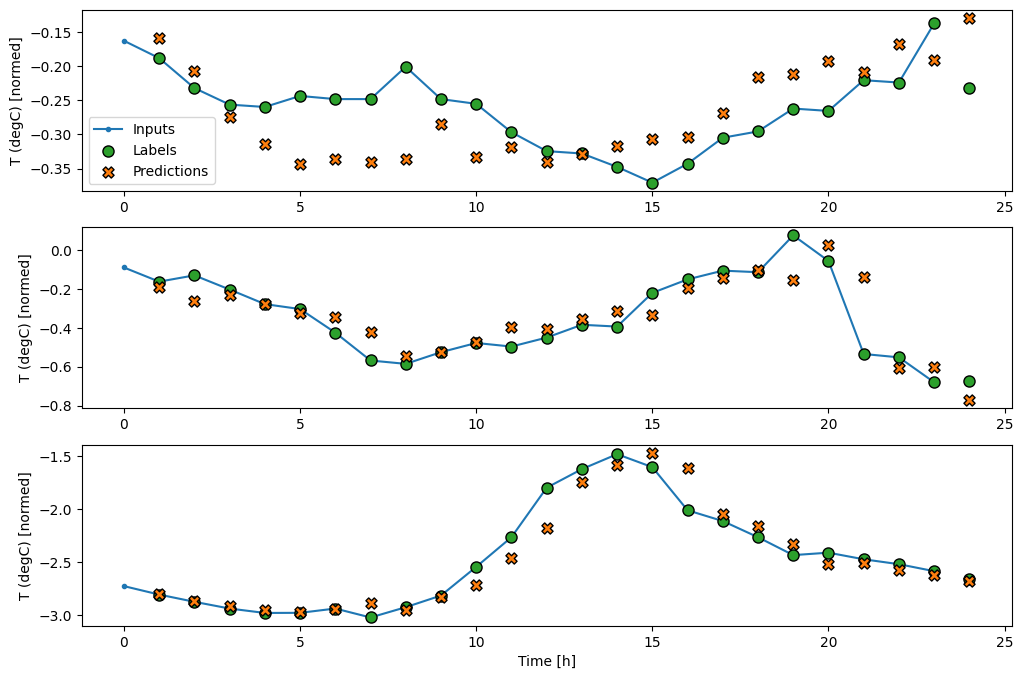

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

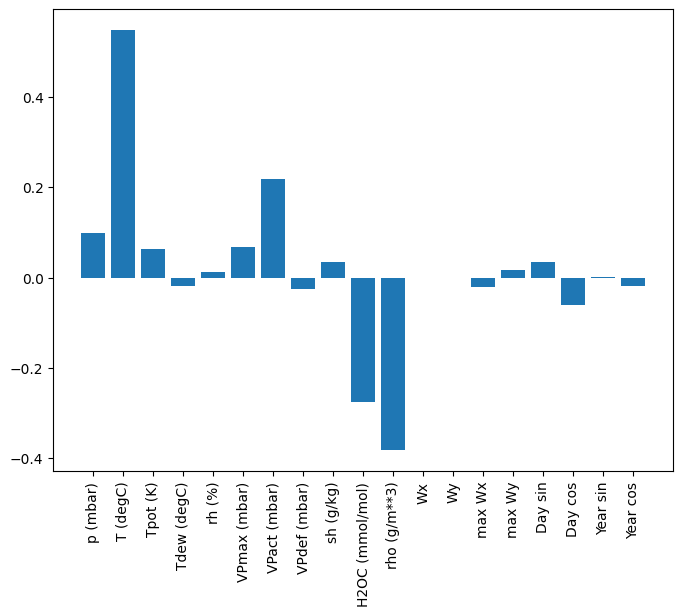

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization.

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output:

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 45:10 2s/step - loss: 1.1741 - mean_absolute_error: 0.8577

  36/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5730 - mean_absolute_error: 0.5364  

  72/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3825 - mean_absolute_error: 0.4079

 108/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2954 - mean_absolute_error: 0.3417

 144/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2442 - mean_absolute_error: 0.3004

 180/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2100 - mean_absolute_error: 0.2716

 216/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1854 - mean_absolute_error: 0.2501

 252/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1666 - mean_absolute_error: 0.2335

 288/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1519 - mean_absolute_error: 0.2201

 324/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1399 - mean_absolute_error: 0.2091

 361/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1297 - mean_absolute_error: 0.1995

 401/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1205 - mean_absolute_error: 0.1907

 440/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1129 - mean_absolute_error: 0.1833

 476/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1069 - mean_absolute_error: 0.1774

 513/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1014 - mean_absolute_error: 0.1720

 549/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0967 - mean_absolute_error: 0.1673

 585/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0925 - mean_absolute_error: 0.1630

 621/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0887 - mean_absolute_error: 0.1592

 657/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0852 - mean_absolute_error: 0.1557

 694/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0820 - mean_absolute_error: 0.1524

 731/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0791 - mean_absolute_error: 0.1493

 768/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0765 - mean_absolute_error: 0.1465

 804/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0741 - mean_absolute_error: 0.1440

 841/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0718 - mean_absolute_error: 0.1416

 878/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0697 - mean_absolute_error: 0.1394

 914/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0677 - mean_absolute_error: 0.1373

 950/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0660 - mean_absolute_error: 0.1354

 986/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0643 - mean_absolute_error: 0.1336

1023/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0627 - mean_absolute_error: 0.1319

1059/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0612 - mean_absolute_error: 0.1303

1095/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0598 - mean_absolute_error: 0.1288

1132/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0585 - mean_absolute_error: 0.1273

1170/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0572 - mean_absolute_error: 0.1259

1208/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0559 - mean_absolute_error: 0.1245

1245/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0548 - mean_absolute_error: 0.1232

1283/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0537 - mean_absolute_error: 0.1220

1321/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0526 - mean_absolute_error: 0.1208

1358/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0517 - mean_absolute_error: 0.1197

1396/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0507 - mean_absolute_error: 0.1186

1433/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0498 - mean_absolute_error: 0.1176

1470/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0490 - mean_absolute_error: 0.1167

1506/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0482 - mean_absolute_error: 0.1158

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0476 - mean_absolute_error: 0.1151

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0476 - mean_absolute_error: 0.1151 - val_loss: 0.0084 - val_mean_absolute_error: 0.0669


Epoch 2/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:25 56ms/step - loss: 0.0064 - mean_absolute_error: 0.0582

  33/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0664   

  70/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087 - mean_absolute_error: 0.0664

 107/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087 - mean_absolute_error: 0.0667

 143/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0668

 181/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0667

 221/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0667

 258/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0665

 294/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0664

 331/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0663

 369/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0662

 407/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0661

 445/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0659

 482/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0659

 519/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0658

 557/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0657

 594/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0657

 630/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0656

 668/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0656

 706/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0655

 743/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0655

 779/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0654

 815/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0654

 852/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0654

 889/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0653

 925/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0653

 962/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0653

 999/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0652

1035/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0652

1071/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0652

1107/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0652

1144/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0652

1181/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0652

1217/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0652

1254/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0651

1291/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0651

1328/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0651

1366/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0651

1403/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0651

1440/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0650

1478/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0650

1514/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0650

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0650 - val_loss: 0.0071 - val_mean_absolute_error: 0.0604


Epoch 3/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:26 57ms/step - loss: 0.0096 - mean_absolute_error: 0.0701

  38/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0629   

  73/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0630

 110/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0630

 148/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0630

 187/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0630

 227/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0630

 264/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0628

 300/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0627

 337/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0627

 374/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0626

 411/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0625

 448/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0625

 485/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0624

 521/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0624

 558/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0624

 594/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0624

 630/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0623

 665/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0623

 701/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0623

 737/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0623

 774/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0622

 810/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0622

 847/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0622

 884/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0622

 921/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0621

 958/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0621

 993/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0621

1032/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0621

1069/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0621

1107/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0620

1144/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0620

1182/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0620

1219/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0620

1256/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0620

1294/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0620

1332/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0620

1370/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0620

1406/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0619

1442/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0619

1478/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0619

1516/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0619

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0619 - val_loss: 0.0071 - val_mean_absolute_error: 0.0611


Epoch 4/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:26 57ms/step - loss: 0.0093 - mean_absolute_error: 0.0729

  36/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0652   

  73/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0645

 110/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0637

 147/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0632

 185/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0628

 226/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0624

 265/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0622

 304/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0620

 342/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0618

 379/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0617

 416/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0616

 453/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0614

 489/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0614

 526/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0613

 564/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0612

 601/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0612

 636/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0611

 672/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0611

 708/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0610

 744/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0610

 781/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0609

 817/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0609

 855/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0609

 892/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0608

 928/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0608

 964/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0608

1003/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1039/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1079/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1118/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1157/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1195/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1233/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1269/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1305/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1343/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1380/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0607

1417/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0606

1453/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0606

1490/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0606

1526/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0606

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0606 - val_loss: 0.0066 - val_mean_absolute_error: 0.0564


Epoch 5/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:24 55ms/step - loss: 0.0065 - mean_absolute_error: 0.0647

  35/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0605   

  71/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0611

 108/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0613

 145/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0612

 183/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0610

 220/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0608

 258/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0606

 293/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0604

 329/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0603

 364/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0602

 400/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0600

 438/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0600

 477/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0599

 514/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0599

 552/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0599

 590/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 630/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 668/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 707/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 744/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 780/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 816/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 852/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 889/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 925/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0598

 960/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0597

 995/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0597

1031/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0597

1068/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0597

1106/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0597

1144/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0597

1180/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0597

1217/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0597

1254/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0597

1291/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0597

1329/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0596

1366/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0596

1402/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0596

1438/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0596

1474/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0596

1511/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0596

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0596 - val_loss: 0.0065 - val_mean_absolute_error: 0.0561


Epoch 6/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:22 54ms/step - loss: 0.0165 - mean_absolute_error: 0.0842

  40/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0615   

  78/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0605

 116/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0600

 156/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0597

 194/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0595

 232/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0593

 269/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0592

 305/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0591

 342/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0590

 379/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0589

 415/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0588

 451/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0588

 488/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0588

 525/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0587

 562/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0587

 600/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0587

 637/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0587

 674/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0587

 709/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0587

 747/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

 784/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

 822/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

 859/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

 896/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

 932/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

 967/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1004/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1040/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1077/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1114/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1151/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1187/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1223/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1258/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1295/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1331/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1368/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

1407/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0587

1444/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0587

1481/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0587

1516/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0587

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0587 - val_loss: 0.0065 - val_mean_absolute_error: 0.0564


Epoch 7/20


   1/1534 ━━━━━━━━━━━━━━━━━━━━ 1:28 57ms/step - loss: 0.0055 - mean_absolute_error: 0.0559

  36/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0601   

  73/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0597

 109/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0594

 146/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0593

 184/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0592

 225/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0591

 265/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0590

 302/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0589

 340/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0588

 379/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0588

 416/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

 452/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0587

 488/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0586

 525/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0586

 563/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0586

 601/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0586

 640/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0585

 677/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0585

 713/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0585

 750/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0585

 786/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0585

 822/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0585

 859/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0585

 895/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0585

 931/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0585

 968/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1006/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1043/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1079/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1115/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1153/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1192/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1231/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1270/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1306/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1342/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1380/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1417/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1454/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1491/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1529/1534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0584

1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0584 - val_loss: 0.0068 - val_mean_absolute_error: 0.0572


  1/439 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - loss: 0.0041 - mean_absolute_error: 0.0466

 40/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0571  

 79/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0568

120/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0568

160/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0569

200/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0569

241/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0569

281/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0569

321/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0570

360/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0570

400/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0570

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0570


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

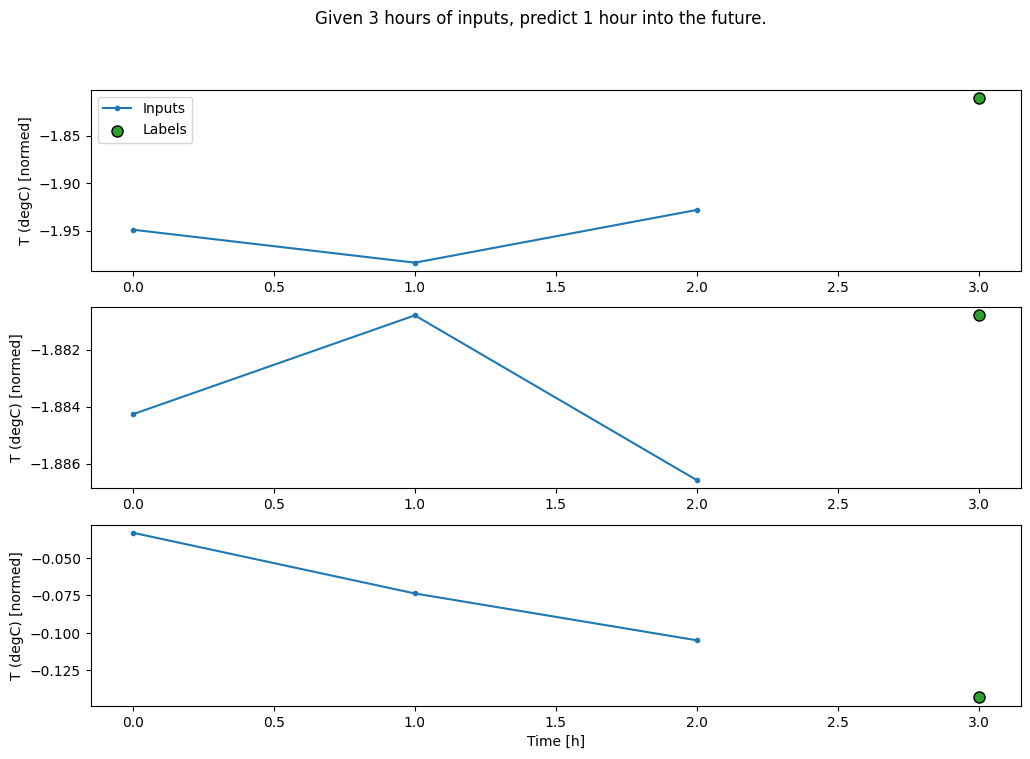

In [48]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

  1/438 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - loss: 0.0044 - mean_absolute_error: 0.0532

 38/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0606  

 83/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0609

125/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0609

169/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - mean_absolute_error: 0.0610

213/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0609

256/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0609

298/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0609

341/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0609

383/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0608

430/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0608

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0608


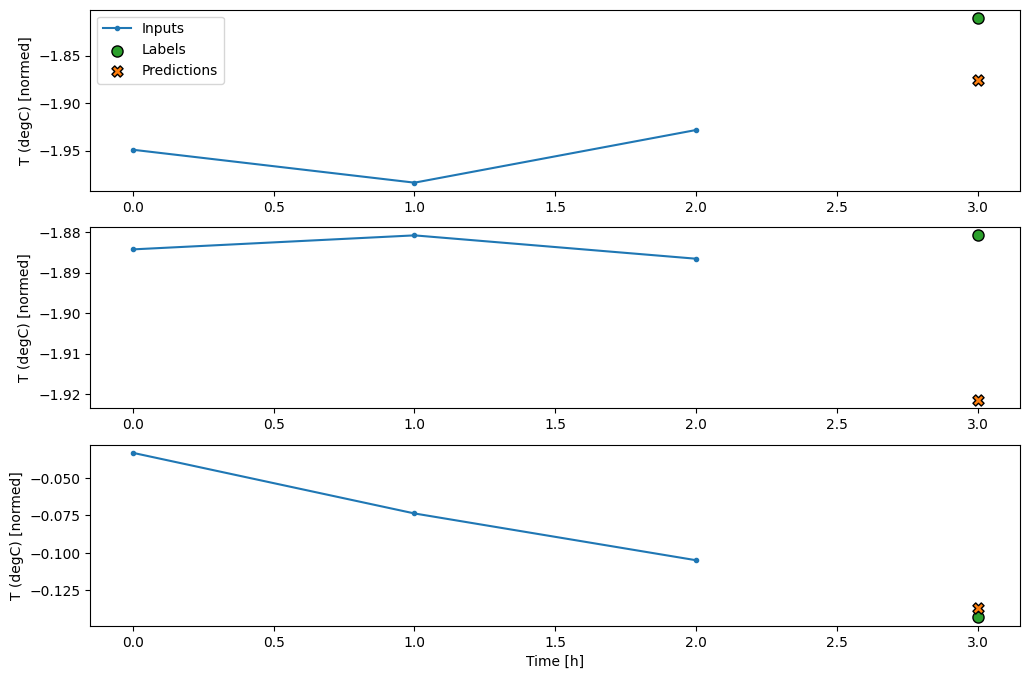

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network

A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution.

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

  1/438 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - loss: 0.0046 - mean_absolute_error: 0.0502

 36/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - mean_absolute_error: 0.0528  

 75/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - mean_absolute_error: 0.0532

114/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - mean_absolute_error: 0.0533

154/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - mean_absolute_error: 0.0533

192/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - mean_absolute_error: 0.0534

231/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - mean_absolute_error: 0.0535

270/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - mean_absolute_error: 0.0537

307/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - mean_absolute_error: 0.0538

344/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - mean_absolute_error: 0.0538

382/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0539

420/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0540

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0540


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


W0000 00:00:1723775965.411205   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.430143   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.431321   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.432466   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.433586   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.434754   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.435894   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.437041   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.438188   80658 gp

Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window


Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


W0000 00:00:1723775965.630979   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.632244   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.633402   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.634575   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.635713   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.636852   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.637993   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.639168   80658 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723775965.640323   80658 gp

Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

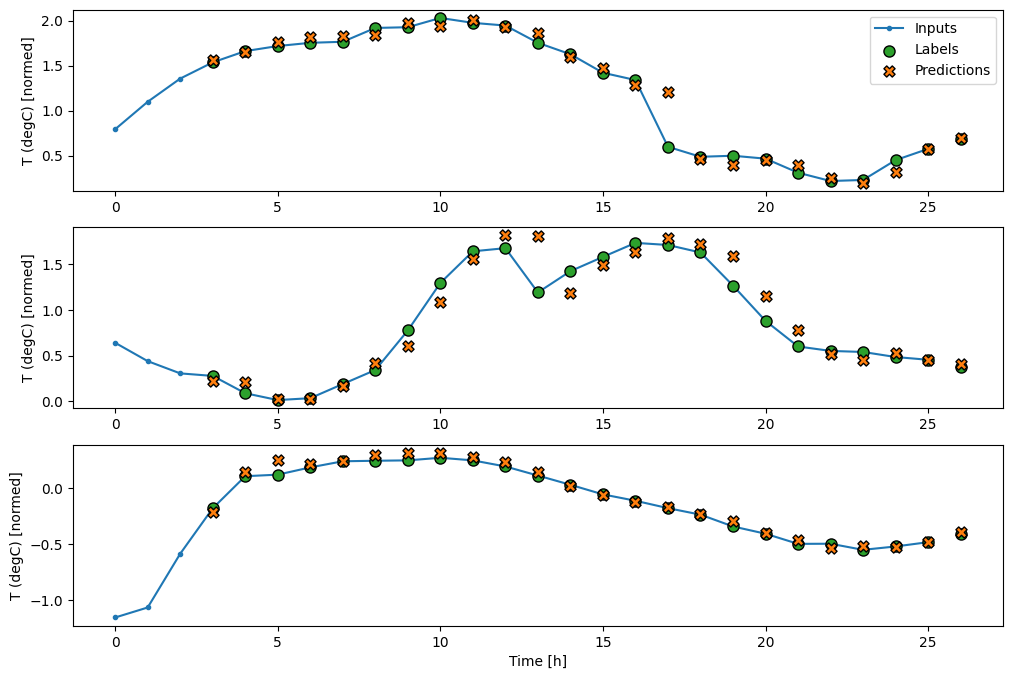

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

  1/438 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - loss: 0.0062 - mean_absolute_error: 0.0525

 24/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mean_absolute_error: 0.0527  

 49/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

 74/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0523

100/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0523

127/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

153/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

178/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

204/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

230/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

257/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

283/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

309/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

336/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

362/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

387/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

414/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0524


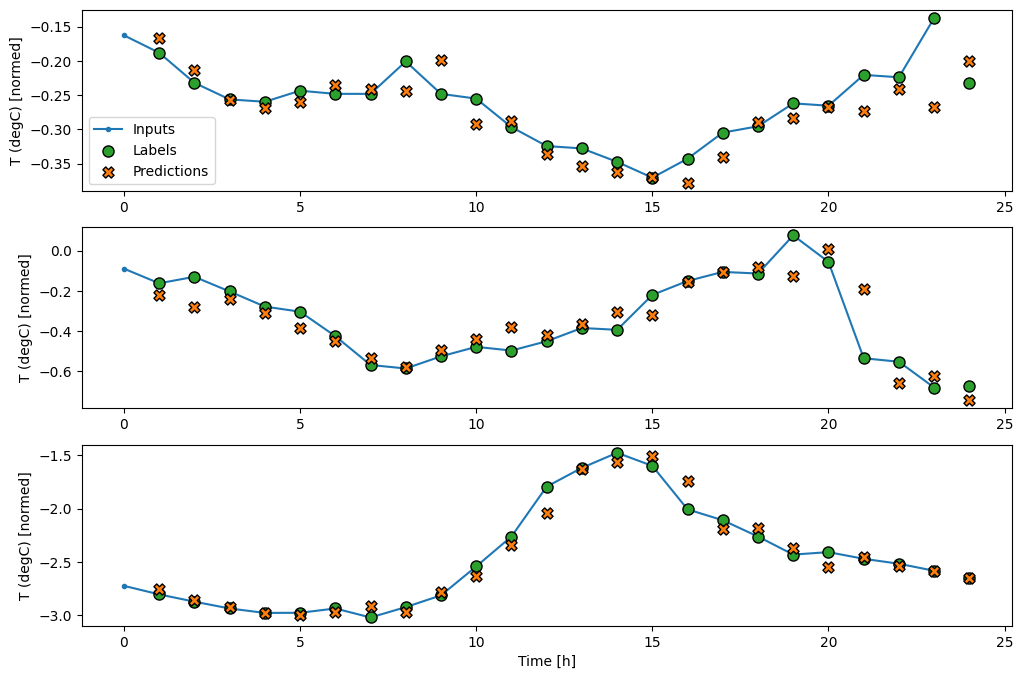

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

In [65]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [66]:
val_performance

{'Baseline': {'loss': 0.012845644727349281,
  'mean_absolute_error': 0.07846628874540329},
 'Linear': {'loss': 0.008695926517248154,
  'mean_absolute_error': 0.06866316497325897},
 'Dense': {'loss': 0.006793886888772249,
  'mean_absolute_error': 0.05716359242796898},
 'Multi step dense': {'loss': 0.007616413291543722,
  'mean_absolute_error': 0.06059327721595764},
 'Conv': {'loss': 0.006222909316420555,
  'mean_absolute_error': 0.05451442673802376},
 'LSTM': {'loss': 0.0056776562705636024,
  'mean_absolute_error': 0.05233458802103996}}

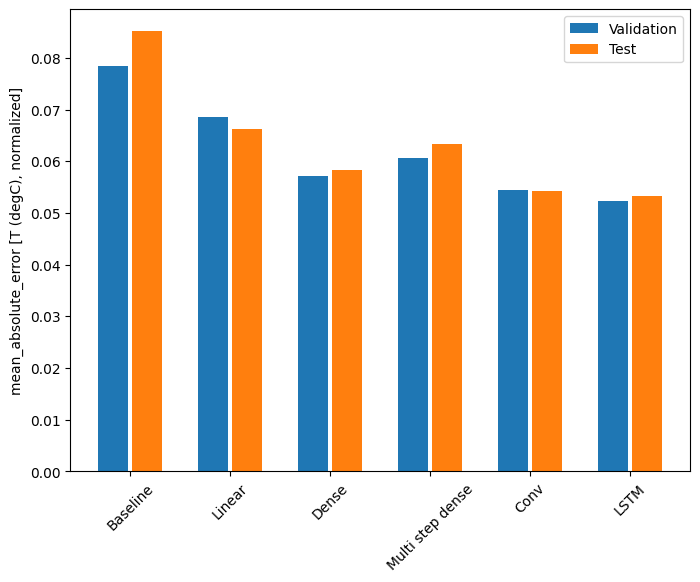

In [67]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [68]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0663
Dense       : 0.0584
Multi step dense: 0.0633
Conv        : 0.0543
LSTM        : 0.0533


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [69]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [70]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [71]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0, return_dict=True)

  1/438 ━━━━━━━━━━━━━━━━━━━━ 2:08 293ms/step - loss: 0.0831 - mean_absolute_error: 0.1571

 41/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0875 - mean_absolute_error: 0.1589    

 84/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0878 - mean_absolute_error: 0.1590

128/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0880 - mean_absolute_error: 0.1590

170/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0882 - mean_absolute_error: 0.1591

213/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0883 - mean_absolute_error: 0.1591

257/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0884 - mean_absolute_error: 0.1591

297/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0884 - mean_absolute_error: 0.1591

338/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0885 - mean_absolute_error: 0.1591

379/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0885 - mean_absolute_error: 0.1591

422/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0885 - mean_absolute_error: 0.1591

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0885 - mean_absolute_error: 0.1591

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0885 - mean_absolute_error: 0.1591


#### Dense

In [72]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [73]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

  1/439 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - loss: 0.0662 - mean_absolute_error: 0.1301

 37/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0697 - mean_absolute_error: 0.1328  

 80/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0694 - mean_absolute_error: 0.1326

121/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0693 - mean_absolute_error: 0.1325

161/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0691 - mean_absolute_error: 0.1323

202/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0690 - mean_absolute_error: 0.1321

244/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0689 - mean_absolute_error: 0.1319

286/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0687 - mean_absolute_error: 0.1316

327/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0686 - mean_absolute_error: 0.1315

369/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0685 - mean_absolute_error: 0.1313

414/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0684 - mean_absolute_error: 0.1312

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0684 - mean_absolute_error: 0.1312


#### RNN


In [74]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()

  1/438 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - loss: 0.0667 - mean_absolute_error: 0.1213

 27/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0614 - mean_absolute_error: 0.1192  

 53/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - mean_absolute_error: 0.1188

 79/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0604 - mean_absolute_error: 0.1187

105/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0605 - mean_absolute_error: 0.1187

132/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0606 - mean_absolute_error: 0.1189

158/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - mean_absolute_error: 0.1191

184/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0608 - mean_absolute_error: 0.1192

210/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0609 - mean_absolute_error: 0.1193

236/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0609 - mean_absolute_error: 0.1194

263/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0610 - mean_absolute_error: 0.1194

290/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0610 - mean_absolute_error: 0.1195

316/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0610 - mean_absolute_error: 0.1195

343/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - mean_absolute_error: 0.1195

369/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - mean_absolute_error: 0.1196

396/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - mean_absolute_error: 0.1196

423/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612 - mean_absolute_error: 0.1196

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0612 - mean_absolute_error: 0.1196



CPU times: user 4min 33s, sys: 51.8 s, total: 5min 25s
Wall time: 1min 57s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial.

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [75]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [76]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

  1/438 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - loss: 0.0711 - mean_absolute_error: 0.1259

 25/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0631 - mean_absolute_error: 0.1193  

 51/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0627 - mean_absolute_error: 0.1189

 77/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0627 - mean_absolute_error: 0.1189

102/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0628 - mean_absolute_error: 0.1189

128/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0627 - mean_absolute_error: 0.1189

153/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0627 - mean_absolute_error: 0.1188

179/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0626 - mean_absolute_error: 0.1188

205/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0625 - mean_absolute_error: 0.1187

230/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0625 - mean_absolute_error: 0.1187

255/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0624 - mean_absolute_error: 0.1186

281/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0623 - mean_absolute_error: 0.1186

307/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0623 - mean_absolute_error: 0.1185

334/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0623 - mean_absolute_error: 0.1185

360/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0623 - mean_absolute_error: 0.1185

386/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0622 - mean_absolute_error: 0.1184

411/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0622 - mean_absolute_error: 0.1184

437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0622 - mean_absolute_error: 0.1184

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0622 - mean_absolute_error: 0.1184



CPU times: user 1min 40s, sys: 19.1 s, total: 1min 59s
Wall time: 43.8 s


#### Performance

Here is the overall performance for these multi-output models.

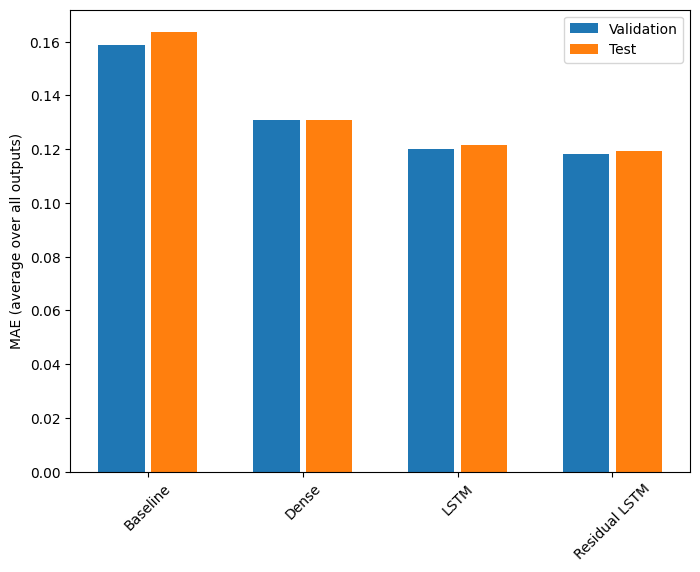

In [77]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [78]:
for name, value in performance.items():
  print(f'{name:15s}: {value[metric_name]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1308
LSTM           : 0.1215
Residual LSTM  : 0.1193


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

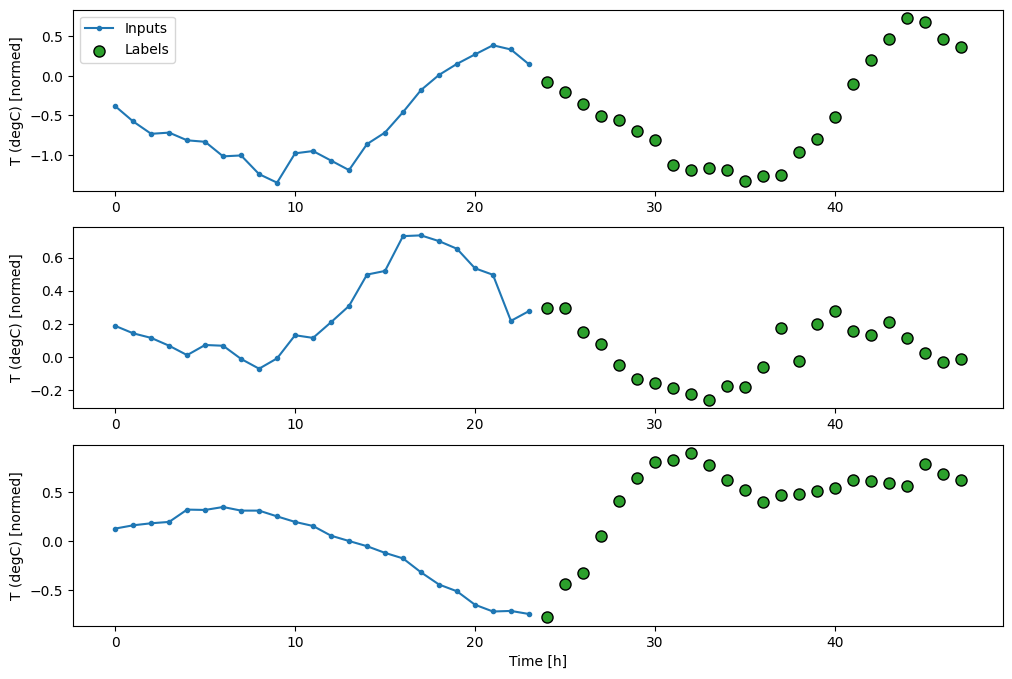

In [79]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

  1/437 ━━━━━━━━━━━━━━━━━━━━ 2:11 303ms/step - loss: 0.6484 - mean_absolute_error: 0.5045

 44/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6169 - mean_absolute_error: 0.4922    

 89/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6219 - mean_absolute_error: 0.4952

132/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6239 - mean_absolute_error: 0.4965

177/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6256 - mean_absolute_error: 0.4976

220/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6266 - mean_absolute_error: 0.4983

264/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6270 - mean_absolute_error: 0.4987

306/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6270 - mean_absolute_error: 0.4989

349/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6270 - mean_absolute_error: 0.4990

394/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6271 - mean_absolute_error: 0.4991

437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6271 - mean_absolute_error: 0.4992

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6271 - mean_absolute_error: 0.4992


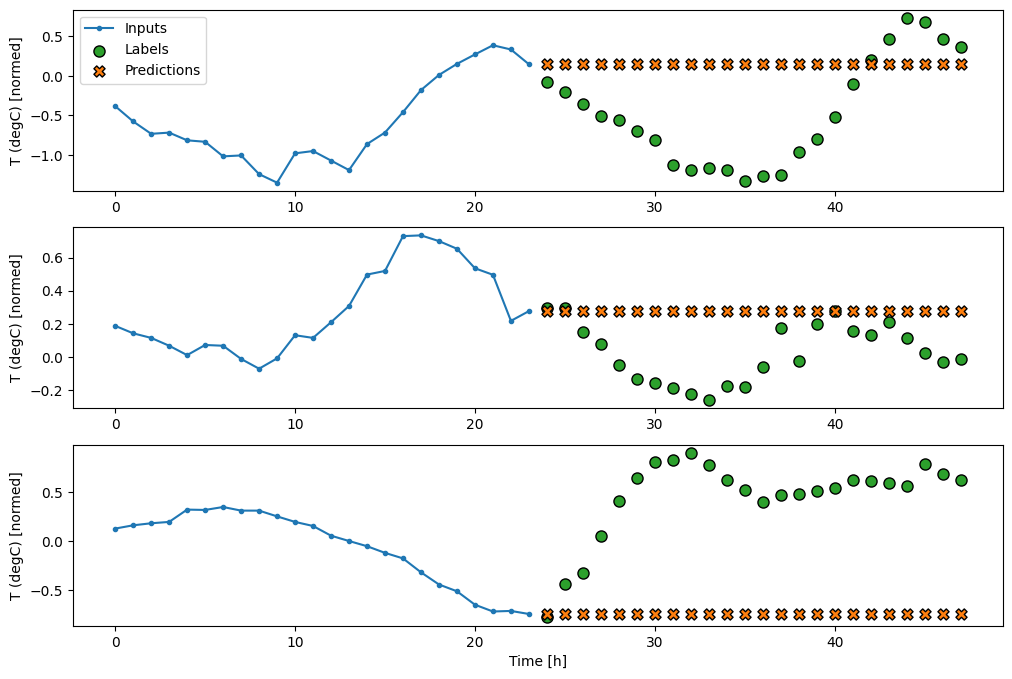

In [80]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

  1/437 ━━━━━━━━━━━━━━━━━━━━ 1:49 250ms/step - loss: 0.4145 - mean_absolute_error: 0.3752

 43/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4137 - mean_absolute_error: 0.3905    

 85/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4186 - mean_absolute_error: 0.3930

129/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4190 - mean_absolute_error: 0.3932

173/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4200 - mean_absolute_error: 0.3935

216/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4208 - mean_absolute_error: 0.3938

257/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4218 - mean_absolute_error: 0.3941

299/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4227 - mean_absolute_error: 0.3944

342/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4233 - mean_absolute_error: 0.3946

384/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4236 - mean_absolute_error: 0.3947

432/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4240 - mean_absolute_error: 0.3948

437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4240 - mean_absolute_error: 0.3948

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4241 - mean_absolute_error: 0.3948


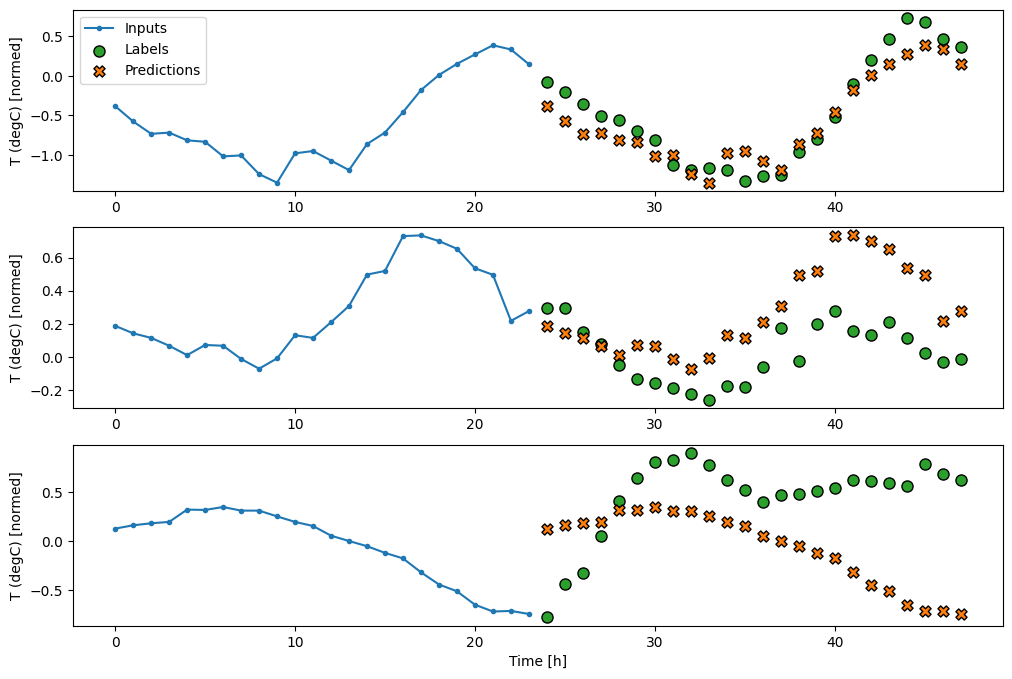

In [81]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

  1/437 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - loss: 0.2524 - mean_absolute_error: 0.3003

 41/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2516 - mean_absolute_error: 0.3044  

 80/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2534 - mean_absolute_error: 0.3051

121/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2544 - mean_absolute_error: 0.3052

162/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2550 - mean_absolute_error: 0.3054

204/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2550 - mean_absolute_error: 0.3054

246/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2549 - mean_absolute_error: 0.3053

284/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2548 - mean_absolute_error: 0.3052

321/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2547 - mean_absolute_error: 0.3051

357/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2547 - mean_absolute_error: 0.3051

394/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2547 - mean_absolute_error: 0.3051

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2547 - mean_absolute_error: 0.3051


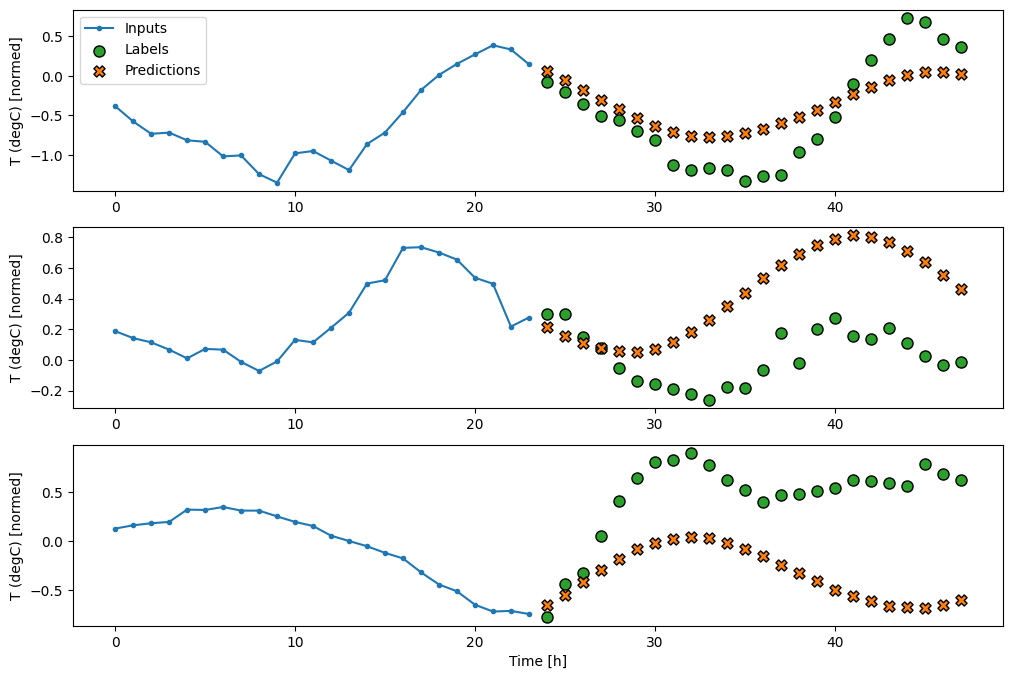

In [82]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

  1/437 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - loss: 0.1709 - mean_absolute_error: 0.2667

 38/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2145 - mean_absolute_error: 0.2803  

 77/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2149 - mean_absolute_error: 0.2798

116/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2148 - mean_absolute_error: 0.2796

155/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2151 - mean_absolute_error: 0.2797

196/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2152 - mean_absolute_error: 0.2796

240/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2153 - mean_absolute_error: 0.2796

282/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2156 - mean_absolute_error: 0.2797

323/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2157 - mean_absolute_error: 0.2797

363/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2158 - mean_absolute_error: 0.2797

404/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2160 - mean_absolute_error: 0.2797

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2161 - mean_absolute_error: 0.2798


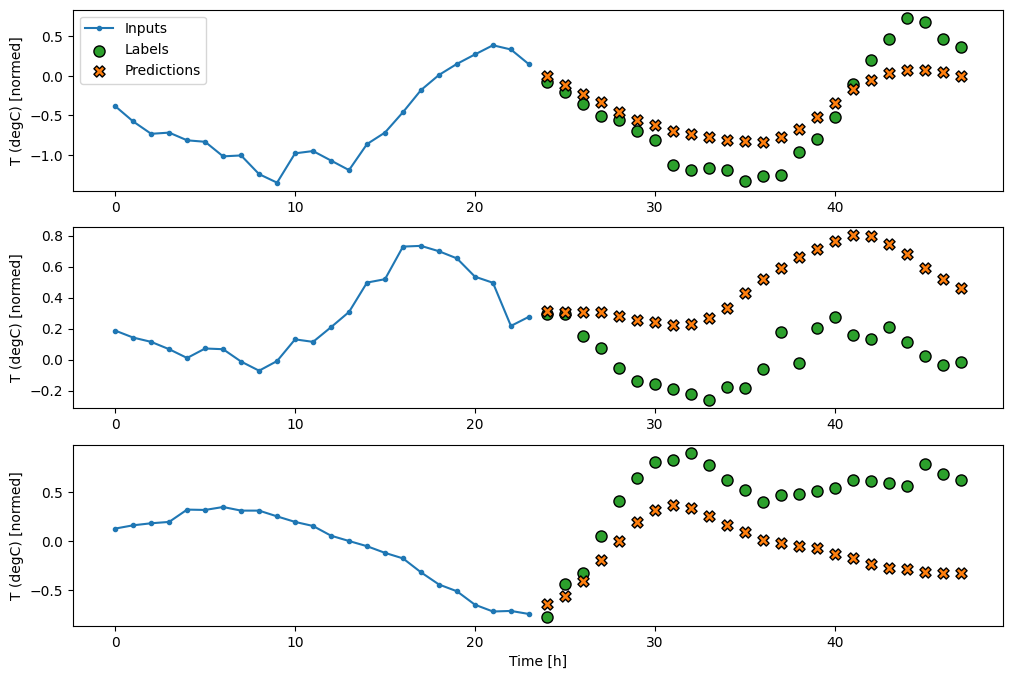

In [83]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

  1/437 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - loss: 0.2232 - mean_absolute_error: 0.2737

 40/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2116 - mean_absolute_error: 0.2784  

 79/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2119 - mean_absolute_error: 0.2788

118/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2122 - mean_absolute_error: 0.2790

155/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2122 - mean_absolute_error: 0.2790

193/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2123 - mean_absolute_error: 0.2790

233/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2125 - mean_absolute_error: 0.2791

274/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2127 - mean_absolute_error: 0.2791

315/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2128 - mean_absolute_error: 0.2792

354/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2130 - mean_absolute_error: 0.2792

392/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2131 - mean_absolute_error: 0.2793

431/437 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2132 - mean_absolute_error: 0.2794

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2133 - mean_absolute_error: 0.2794


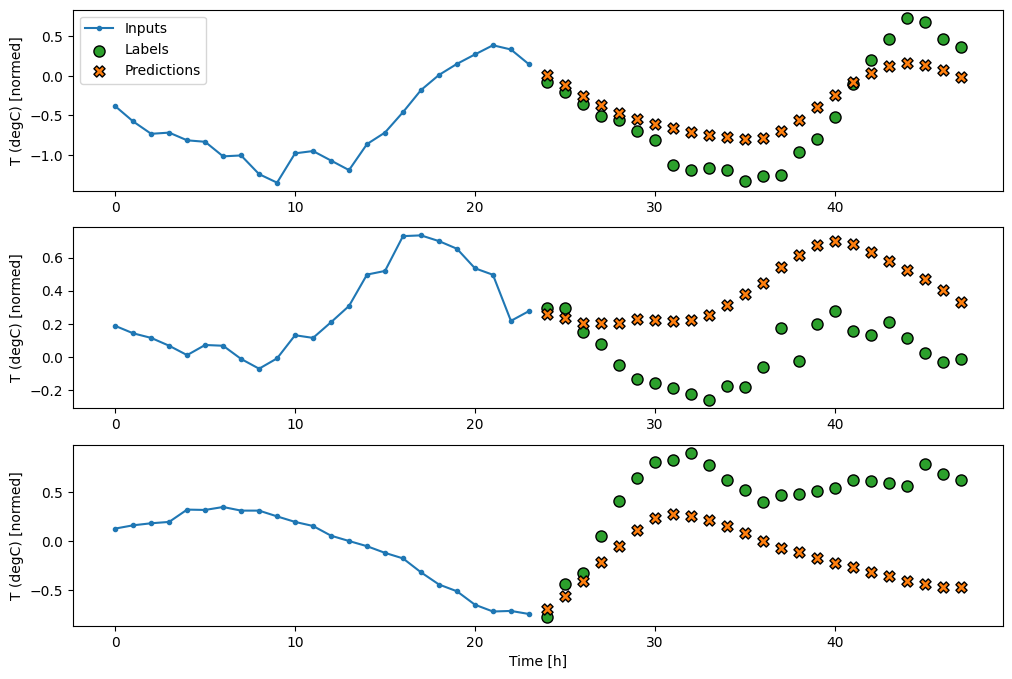

In [84]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


  1/437 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - loss: 0.2065 - mean_absolute_error: 0.2797

 24/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2136 - mean_absolute_error: 0.2837  

 50/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2127 - mean_absolute_error: 0.2833

 76/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2124 - mean_absolute_error: 0.2831

101/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2131 - mean_absolute_error: 0.2836

126/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2139 - mean_absolute_error: 0.2842

151/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2145 - mean_absolute_error: 0.2847

177/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2149 - mean_absolute_error: 0.2849

203/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2150 - mean_absolute_error: 0.2851

229/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2152 - mean_absolute_error: 0.2852

255/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2153 - mean_absolute_error: 0.2854

281/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2155 - mean_absolute_error: 0.2855

307/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2156 - mean_absolute_error: 0.2856

334/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2157 - mean_absolute_error: 0.2856

360/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2158 - mean_absolute_error: 0.2857

385/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2159 - mean_absolute_error: 0.2857

409/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2159 - mean_absolute_error: 0.2857

435/437 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2160 - mean_absolute_error: 0.2858

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2160 - mean_absolute_error: 0.2858


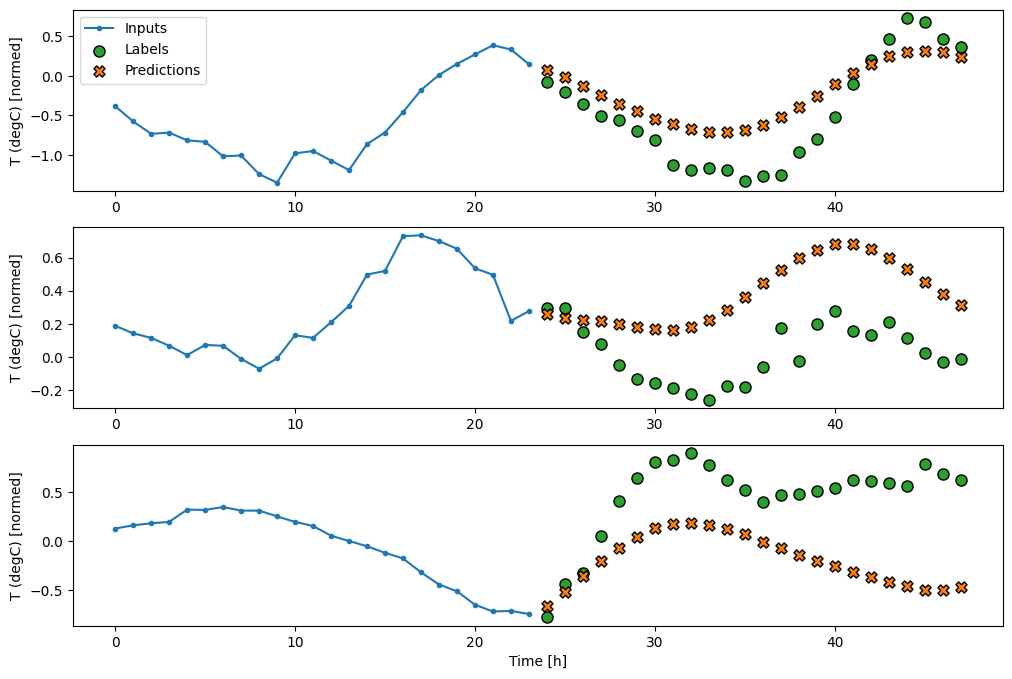

In [85]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [86]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [87]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [88]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [89]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [90]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [91]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now, train the model:

  1/437 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - loss: 0.2044 - mean_absolute_error: 0.2868

 20/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2239 - mean_absolute_error: 0.2994  

 40/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2252 - mean_absolute_error: 0.2986

 61/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2250 - mean_absolute_error: 0.2982

 81/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2249 - mean_absolute_error: 0.2979

102/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2246 - mean_absolute_error: 0.2977

123/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2243 - mean_absolute_error: 0.2976

144/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2241 - mean_absolute_error: 0.2974

164/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2240 - mean_absolute_error: 0.2973

185/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2241 - mean_absolute_error: 0.2973

206/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2242 - mean_absolute_error: 0.2973

225/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2242 - mean_absolute_error: 0.2973

245/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2242 - mean_absolute_error: 0.2973

266/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2243 - mean_absolute_error: 0.2973

286/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2243 - mean_absolute_error: 0.2973

306/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2243 - mean_absolute_error: 0.2974

325/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2243 - mean_absolute_error: 0.2974

345/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2243 - mean_absolute_error: 0.2974

365/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2244 - mean_absolute_error: 0.2974

384/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2244 - mean_absolute_error: 0.2974

404/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2244 - mean_absolute_error: 0.2973

423/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2244 - mean_absolute_error: 0.2973

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2244 - mean_absolute_error: 0.2973


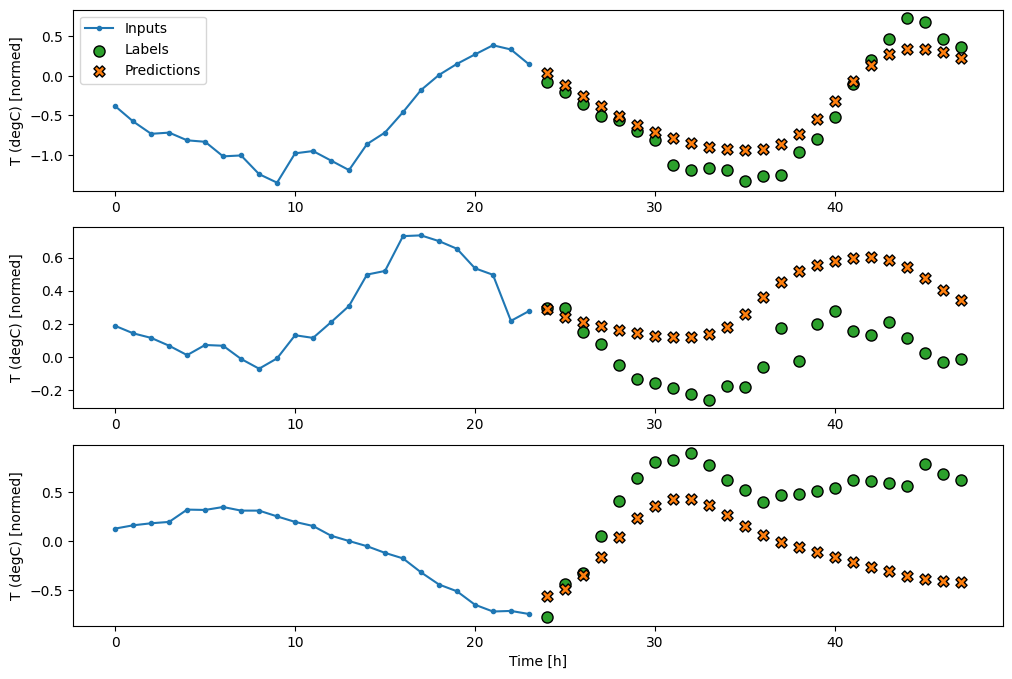

In [92]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

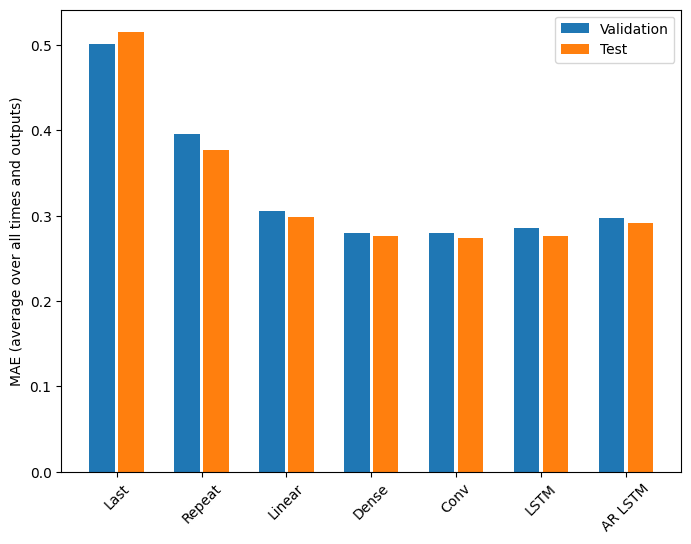

In [93]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps.

In [94]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2980
Dense   : 0.2765
Conv    : 0.2732
LSTM    : 0.2767
AR LSTM : 0.2910


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
